In [ ]:
import os
from dotenv import load_dotenv
load_dotenv(override=True)

os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
os.environ["LANGCHAIN_API_KEY"] = os.getenv('LANGCHAIN_API_KEY')
MODEL_NAME = "llama-3.1-8b-instant"

In [ ]:
from langchain_community.document_loaders import WebBaseLoader 
from langchain_community.vectorstores import FAISS 
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings

In [ ]:
urls = [
    'https://docs.langchain.com/oss/python/langgraph/streaming',
    'https://docs.langchain.com/oss/python/langgraph/interrupts',
    'https://docs.langchain.com/oss/python/langgraph/persistence'
]

docs = [WebBaseLoader(url).load() for url in urls]
docs

In [ ]:
doc_list = [doc for sublist in docs for doc in sublist]
doc_list

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
doc_splits = text_splitter.split_documents(doc_list)
doc_splits

In [5]:
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
vectorstore = FAISS.from_documents(documents=doc_splits, embedding=embeddings)

retriever = vectorstore.as_retriever()

In [ ]:
retriever.invoke("How to get the full history of Graph execution?")

In [7]:
# Retriever to retriever tools 

from langchain.tools.retriever import create_retriever_tool 
from langchain.tools import Tool

retreiever_tool = create_retriever_tool(
    retriever,
    "retriever_vector_db_blog",
    "Search and run information about LangGraph"
)
# retreiever_tool = Tool(
#     name="retriever_vector_db_blog",
#     func=retriever.invoke,
#     description="Search and run information about LangGraph"
# )

### LangChain retriever and tool

In [ ]:
urls = [
    'https://docs.langchain.com/oss/python/langchain/install',
    'https://docs.langchain.com/oss/python/langchain/models',
    'https://docs.langchain.com/oss/python/langchain/middleware'
]

docs = [WebBaseLoader(url).load() for url in urls]

doc_list = [doc for sublist in docs for doc in sublist]

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
doc_splits = text_splitter.split_documents(doc_list)

embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
vectorstore_langchain = FAISS.from_documents(documents=doc_splits, embedding=embeddings)

retriever_langchain = vectorstore_langchain.as_retriever()

retriever_langchain.invoke("What's the command for Langchain Open AI integration?")

In [9]:
retreiever_tool_langchain = create_retriever_tool(
    retriever_langchain,
    "retriever_vector_langchain_blog",
    "Search and run information about LangChain"
)
# retreiever_tool_langchain = Tool(
#     name="retriever_vector_langchain_blog",
#     func=retriever_langchain.invoke,
#     description="Retrieve relevant documents about LangChain."
# )


In [18]:
tools = [retreiever_tool, retreiever_tool_langchain]

### LangGraph Workflow

In [11]:
from typing import Annotated, Sequence 
from typing_extensions import TypedDict, Literal 
from pydantic import BaseModel, Field
from langchain import hub
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [12]:
from langchain_groq import ChatGroq
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')

llm = ChatGroq(model=MODEL_NAME)


In [13]:
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given the question, it will decide whether to retrieve using the retriever tool or simply end.

    Args: 
        state (messages): the current state 
    Returns: 
        dict: The updated state with agent response appended to the messages
    """
    print("--- CALL Agent ---")
    messages = state['messages']
    model = ChatGroq(model=MODEL_NAME)
    model = model.bind_tools(tools)

    response = model.invoke(messages)

    print("--- Agent response: ", response)

    return {"messages": [response]}

In [34]:
# Edges 
def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retreived documents are relevant to the question. 

    Args: 
        state (messages): The current state. 
    Returns: 
        str: A decision for whether the documents are relevant or not.
    """
    print("--- CHECK RELEVANCE ---")

    class grade(BaseModel):
        """Binary score for relevance check"""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    model = ChatGroq(model=MODEL_NAME)
    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of retrieved documents for a user's question.\n
        Here is the retrieved document: \n\n{context}\n\n
        Here is the user's question: \n{question}\n\n
        If the document contains relevant keywords or semantic meaning related to the user question, grade it as relevant.\n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
        """,
        input_variables=["context", "question"]
    )
    chain = prompt | llm_with_tool

    messages = state['messages']
    last_message = messages[-1]
    question = messages[0].content 
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})
    
    print("Scored result: ", scored_result)

    # Handle both possible return types
    # if isinstance(scored_result, dict):
    #     score = scored_result.get("binary_score")
    # else:
    #     score = getattr(scored_result, "binary_score", None)

    score = scored_result.binary_score
    print("Score:", score)

    if score == 'yes':
        print("---DECISION DOCS RELEVANT---", score)
        return "generate"
    else: 
        print("---DECISION DOCS NOT RELEVANT---", score)
        return "rewrite"

In [35]:
def generate(state):
    """
    Generate answer

    Args: 
        state (messages): The current state. 
    Returns: 
        dict: The updated message.
    """
    print("--- GENERATE ANSWER ---")
    messages = state['messages']
    last_message = messages[-1]
    question = messages[0].content 
    docs = last_message.content

    # prompt = hub.pull('rlm/rag-default-prompt')

    prompt = PromptTemplate(
        template=(
            "You are a helpful AI assistant.\n"
            "Use the following retrieved context to answer the user question accurately.\n\n"
            "Context:\n{content}\n\n"
            "Question:\n{question}\n\n"
            "Answer:"
        ),
        input_variables=["content", "question"],
    )

    llm = ChatGroq(model=MODEL_NAME)

    # Post processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)
    
    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run 
    response = rag_chain.invoke({"content": docs, "question": question})
    return {"messages": [response]}


In [36]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state
    Returns: 
        dict: The updated state with rephrased question
    """
    print("--- TRANSFORM QUERY ---")
    messages = state['messages']
    question = messages[0].content 

    msg = [
        HumanMessage(
            content=f"""\n Look at the input and try to reason about the underlying semantic intent/meaning.\n
            Here is the initial question:\n
            \n--------\n
            {question}
            \n--------\n
            Formulate the improved question: 
            """
        )
    ]

    model = ChatGroq(model=MODEL_NAME)
    response = model.invoke(msg)
    return {"messages": [response]}

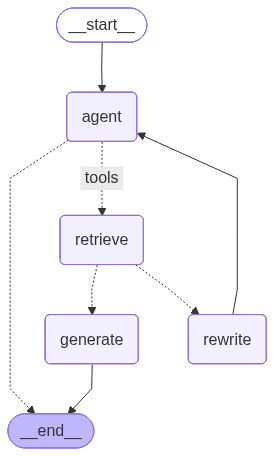

In [37]:
from langgraph.graph import START, END, StateGraph 
from langgraph.prebuilt import ToolNode, tools_condition 

# Define a new graph 
workflow = StateGraph(AgentState)

# Define the nodes
workflow.add_node("agent", agent)
retrieve = ToolNode([retreiever_tool, retreiever_tool_langchain])
workflow.add_node("retrieve", retrieve)
workflow.add_node("rewrite", rewrite)
workflow.add_node("generate", generate) # Generate resp after we know the relevant docs 

# Edges 
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        "tools": "retrieve",
        END: END
    }
)
# Edges taken after the "action" node is called
workflow.add_conditional_edges("retrieve", grade_documents)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

graph = workflow.compile()

from IPython.display import Image, display 

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))




In [ ]:
graph.invoke({"messages": "How to create parallel workflow in LangGraph?"})

--- CALL Agent ---
--- Agent response:  content='' additional_kwargs={'tool_calls': [{'id': 'm4a0fxavb', 'function': {'arguments': '{"query":"What is LangChain?"}', 'name': 'retriever_vector_langchain_blog'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 310, 'total_tokens': 332, 'completion_time': 0.02935421, 'prompt_time': 0.018707355, 'queue_time': 0.053183465, 'total_time': 0.048061565}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_7b3cfae3af', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--1856e64a-40db-4259-846e-ae7d970f93d7-0' tool_calls=[{'name': 'retriever_vector_langchain_blog', 'args': {'query': 'What is LangChain?'}, 'id': 'm4a0fxavb', 'type': 'tool_call'}] usage_metadata={'input_tokens': 310, 'output_tokens': 22, 'total_tokens': 332}
--- CHECK RELEVANCE ---
Scored result:  binary_score='yes'
Score: yes
---DECISION DOCS RELEVANT--- yes
--- GENERATE ANSWER ---


{'messages': [HumanMessage(content='What is LangChain?', additional_kwargs={}, response_metadata={}, id='725366d9-00c3-451a-be5d-c1067a287bf0'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'm4a0fxavb', 'function': {'arguments': '{"query":"What is LangChain?"}', 'name': 'retriever_vector_langchain_blog'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 310, 'total_tokens': 332, 'completion_time': 0.02935421, 'prompt_time': 0.018707355, 'queue_time': 0.053183465, 'total_time': 0.048061565}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_7b3cfae3af', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--1856e64a-40db-4259-846e-ae7d970f93d7-0', tool_calls=[{'name': 'retriever_vector_langchain_blog', 'args': {'query': 'What is LangChain?'}, 'id': 'm4a0fxavb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 310, 'output_tokens': 22, 'total_tokens': 332}),
  ToolM